In [30]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [31]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

labels, data = np.array(train['labels'], dtype=np.float64) , np.array(train['data'], dtype=np.float64) # Сonversion to float!

In [32]:
# Show i'th image
def show_image(img):
    plt.imshow(img.reshape(28,28))

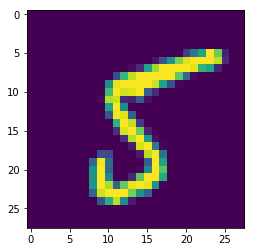

In [33]:
# Normalizing and classification -1/+1
def pixel_norm(x):
    for img in x:
        img = img/255
    return x

def classification(y):
    for label in y:
        label=-1 if label==5 else 1
    return y

data = pixel_norm(data)
labels = classification(labels)

show_image(data[0])

# Создание модели

In [34]:
# Creating two perceptrons in output layer
'''Global weight declaration for multiple runs capabilities'''

np.random.seed(10)
w = np.random.normal(scale=0.001, size = data.shape[1])

In [35]:
# k-fold Cross Validation Scheme with shuffling
'''k-fold must be 'None' or 2,3..'''

k_fold = 20

def cross_validation(data, labels):
    global x_train, y_train
    data_set = np.insert(data, 0, labels, axis=1) # Insert labels(y) in each image(x) row
    random.shuffle(data_set)
    if k_fold != None:
        global x_valid, y_valid 
        train = np.asarray([x for i, x in enumerate(data_set) if i % k_fold != 1])
        valid = np.asarray([x for i, x in enumerate(data_set) if i % k_fold == 1])
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]] 
        y_valid, x_valid = valid[:, 0], valid[:, np.r_[1:train.shape[1]]]
        print("Training images:", x_train.shape[0])
        print("Validation images:", x_valid.shape[0])
    else:
        train = np.asarray(data_set)
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]]
        print("Validation images:", x_train.shape[0])

# Обучаем модель

In [36]:
# Stochastic gradient descent
def grad(x, y, weight):
    return (-1)*y*x/(1 + np.exp(y*np.dot(weight.T, x))) + (reg_param**2)*weight

In [37]:
# Logloss calculation
def logloss(x, y, weight):
    buffer = 0
    for i,img in enumerate(x):
        buffer += np.log(1 + np.exp(-y[i]*np.dot(weight.T, img)))
    return buffer

In [38]:
# SGD
def SGD(x, y, weight):
    return learn_rate*grad(x, y, weight)

In [39]:
def accuracy(x, y, weight):
    n_all = x.shape[0]
    n_true = 0
    for i,img in enumerate(x):
        probability = 1/(1+np.exp(-y[i]*np.dot(weight.T, img)))
        if probability > 0.5:
            y_predicted = 1
        else:
            y_predicted = -1
        if (y_predicted == y[i]):
            n_true += 1
    return n_true/n_all

In [40]:
# Learning epoch
def launch_train(w):
    buf_loss_train = 0
    buf_loss_valid = 0
    loss_tr = []
    loss_val = []
    acc_tr = []
    acc_val = []
    epoch = int(y_train.shape[0]/num_of_epoch)
    for it in tqdm.tqdm_notebook(range(epoch)):
        j = np.random.randint(0, y_train.shape[0])    
        
        w -= SGD(x_train[j], y_train[j], w)
        
        buf_loss_train = logloss(x_train, y_train, w)
              
        if ((it+1) % batch_size == 0):
            buf_loss_valid = logloss(x_valid, y_valid, w)
            
            loss_tr.append(buf_loss_train/batch_size)  
            loss_val.append(buf_loss_valid/batch_size)           
            
            acc_tr.append(accuracy(x_train, y_train, w))
            acc_val.append(accuracy(x_valid, y_valid, w))
            
            buf_loss_train = 0
            buf_loss_valid = 0
    return loss_tr, loss_val, acc_tr, acc_val

In [44]:
# Launch
batch_size = 10
num_of_epoch = 100
reg_param = 0.01
learn_rate = 0.001

cross_validation(data, labels)
loss_train, loss_valid, acc_train, acc_valid = launch_train(w)

Training images: 9500
Validation images: 500


/home/dimone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

Training Loss:  0.0


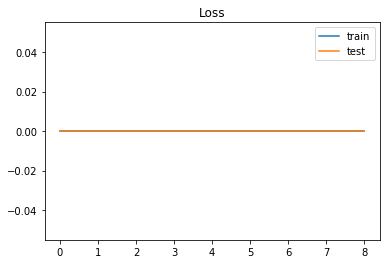

In [42]:
plt.title('Loss')
plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='test')
plt.legend()

print("Training Loss: ", loss_train[-1])

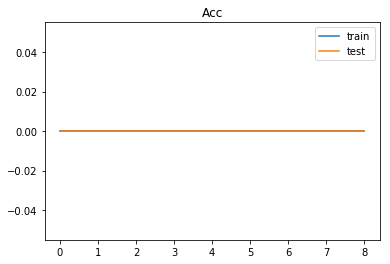

In [43]:
plt.title('Acc')
plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='test')
plt.legend()

Вероятность того, что это 5 -  0.6524956374101241 ;
Вероятность того, что это 6 -  0.34750436258987594


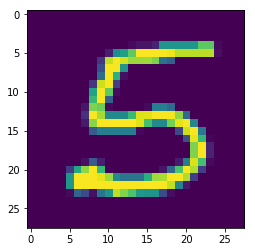

In [15]:
def predict(x): 
    return 1 / (1 + np.exp(-np.dot(w, x)))


p_valid = np.zeros((x_valid.shape[0]))


for i in range(x_valid.shape[0]):
    p_valid[i] = predict(x_valid[i])
    

k = 499
print("Вероятность того, что это 5 - ", 1 - p_valid[k], ";\nВероятность того, что это 6 - ", p_valid[k])
show_image(x_valid[k])


In [16]:
def logloss(true_label, p):
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)
    
for i in range(x_valid.shape[0]):
    lgs_buf = logloss(y_valid[i], p_valid[i])  
    
print(lgs_buf)

0.4269508257691354


# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

NameError: name 'logloss_array' is not defined

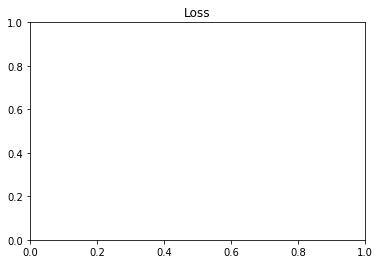

In [17]:
plt.title('Loss')
plt.plot(logloss_array[0], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

In [ ]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

0.4988092886654774


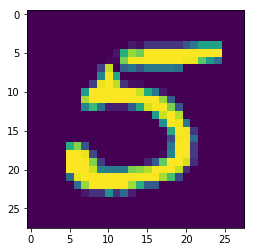

In [21]:
X = np.asfarray(test_no_lables['data'])
X = X / 255

# compute Y_pred
Y_pred = np.zeros(X.shape[0], dtype=float)
for i in range(X.shape[0]):
    Y_pred[i] = predict(X[i])    

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(X.shape[0]):
        print(i, Y_pred[i], sep=',', file=fout)

k = 789
show_image(X[k])
print(Y_pred[k])

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb